In [495]:
from utils import *

In [496]:
df = pd.read_pickle("./data/decade_price_data_combined_01_09.pkl")

In [471]:
class LSTMModel_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel_1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

        # self.sigmoid  = nn.Sigmoid()

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)

        # out = self.sigmoid(out)

        return out

In [472]:
model = LSTMModel_1(78, 512, 5, 1).to(device=DEVICE).eval()
model.load_state_dict(
    torch.load("./models/lstm_training_04_09_2023.pth")
);

In [473]:
distance_2023 = pd.read_csv(
    "./data/distances/distances_2023_decade_price_data_01_09.csv"
).set_index("Qid1")

In [474]:
qids = np.array([9860, 9673, 9855, 9333])

In [476]:
def Reward(outputs, price):
    reward = outputs * price
    return reward

In [477]:
data_X = torch.split(
    torch.load("data/X_test_lstm_decade_price_01_09.pt")
    .permute(0, 1, 3, 2)
    .to(torch.float32),
    1,
)
data_x = torch.split(
    torch.load("data/x_test_lstm_decade_price_01_09.pt").to(torch.float32), 1
)

In [478]:
price_mean, price_std = (21.230517726667767, 13.387471717906585)

In [479]:
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in enumerate(zip(data_X, data_x)):
    for j, price in enumerate(np.linspace(0, 500, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        mean_b = model(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward

In [480]:
data_X = torch.split(
    torch.load("data/X_test_lstm_decade_price_04_09.pt")
    .permute(0, 1, 3, 2)
    .to(torch.float32),
    1,
)
data_x = torch.split(
    torch.load("data/x_test_lstm_decade_price_04_09.pt").to(torch.float32), 1
)

In [481]:
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in enumerate(zip(data_X, data_x)):
    for j, price in enumerate(np.linspace(0, 100, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        mean_b = model(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward

In [482]:
test_qids = [9333.,   9339.,   9340.,   9350.,   9352.,   9394.,   9400.,
             9404.,   9405.,   9502.,   9503.,   9525.,   9526.,   9641.,
             9642.,   9815.,   9816.,   9817.,   9818.,   9846.,   9847.,
             9858.,   9859.,   9932.,   9933., 785704., 931305., 931326.,
             9855.,   9948.,  20457.,  20472.,  20594.,  20595.,  20643.,
             20775.,  20917.,  20918.,  20919.,  20941.,  24605.,  26395.,
             26396., 327508., 327509., 344212., 814900., 840435., 842866.,
             887322., 931310., 931324.,   9860.,   9672.,   9673.,   9674.]

test_qids.sort()

In [483]:
data = pd.read_pickle("./data/decade_price_data_combined_01_09.pkl")
data = data[data.GJ == 2023]
data.sort_values(by="Qid", inplace=True)

In [484]:
qid_9333_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis"])
qid_9855_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis"])
qid_9673_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis"])
qid_9860_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis"])

In [485]:
neighbourhood = {9333 : np.array([9333, 9339.,   9340.,   9350.,   9352.,   9394.,   9400.,
                                  9404.,   9405.,   9502.,   9503.,   9525.,   9526.,   9641.,
                                  9642.,   9815.,   9816.,   9817.,   9818.,   9846.,   9847.,
                                  9858.,   9859.,   9932.,   9933., 785704., 931305., 931326.]),
              
               9855 : np.array([9855, 9948.,  20457.,  20472.,  20594.,  20595.,  20643.,
                                20775.,  20917.,  20918.,  20919.,  20941.,  24605.,  26395.,
                                26396., 327508., 327509., 344212., 814900., 840435., 842866.,
                                887322., 931310., 931324.]),
               
               9673 : np.array([9673, 9672., 9674.]),
               
               
               9860 : np.array([9860.])
              }

new_history = {}

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

for k, qid in enumerate(test_qids):
    peak_ids = scipy.signal.find_peaks(history[k, 2])[0]
    prices = history[k, 0, peak_ids]
    new_history[qid] = find_nearest(prices, data[data.Qid == qid].Preis.values)
#     ids = find_nearest(prices, data[data.Qid == qid].Preis.values)  
#     new_history[qid] = peak_ids[ids]

In [486]:
qids = np.array([9333,9855, 9673, 9860])

In [487]:
qid_9333_data["Qid"] = sorted(neighbourhood[9333])
qid_9855_data["Qid"] = sorted(neighbourhood[9855])
qid_9673_data["Qid"] = sorted(neighbourhood[9673])
qid_9860_data["Qid"] = sorted(neighbourhood[9860])

In [488]:
qid_9333_data["Preis"] = data[data.Qid.isin(neighbourhood[9333])].Preis.values
qid_9855_data["Preis"] = data[data.Qid.isin(neighbourhood[9855])].Preis.values
qid_9673_data["Preis"] = data[data.Qid.isin(neighbourhood[9673])].Preis.values
qid_9860_data["Preis"] = data[data.Qid.isin(neighbourhood[9860])].Preis.values

In [489]:
qid_data=[qid_9333_data, qid_9855_data, qid_9673_data,qid_9860_data]

In [490]:
for j, qid in enumerate(neighbourhood[9333]):
    qid_9333_data.iloc[j, 2] = new_history[qid]
    
for j, qid in enumerate(neighbourhood[9855]):
    qid_9855_data.iloc[j, 2] = new_history[qid]
    
for j, qid in enumerate(neighbourhood[9673]):
    qid_9673_data.iloc[j, 2] = new_history[qid]
    
for j, qid in enumerate(neighbourhood[9860]):
    qid_9860_data.iloc[j, 2] = new_history[qid]

In [491]:
# color = (qid_9855_data.Optimal_preis-qid_9855_data.Preis)/qid_9855_data.Preis*100
color = (qid_9333_data.Optimal_preis-qid_9333_data.Preis)/qid_9333_data.Preis*100
d=qid_9333_data.copy()
d['Percentage']=color

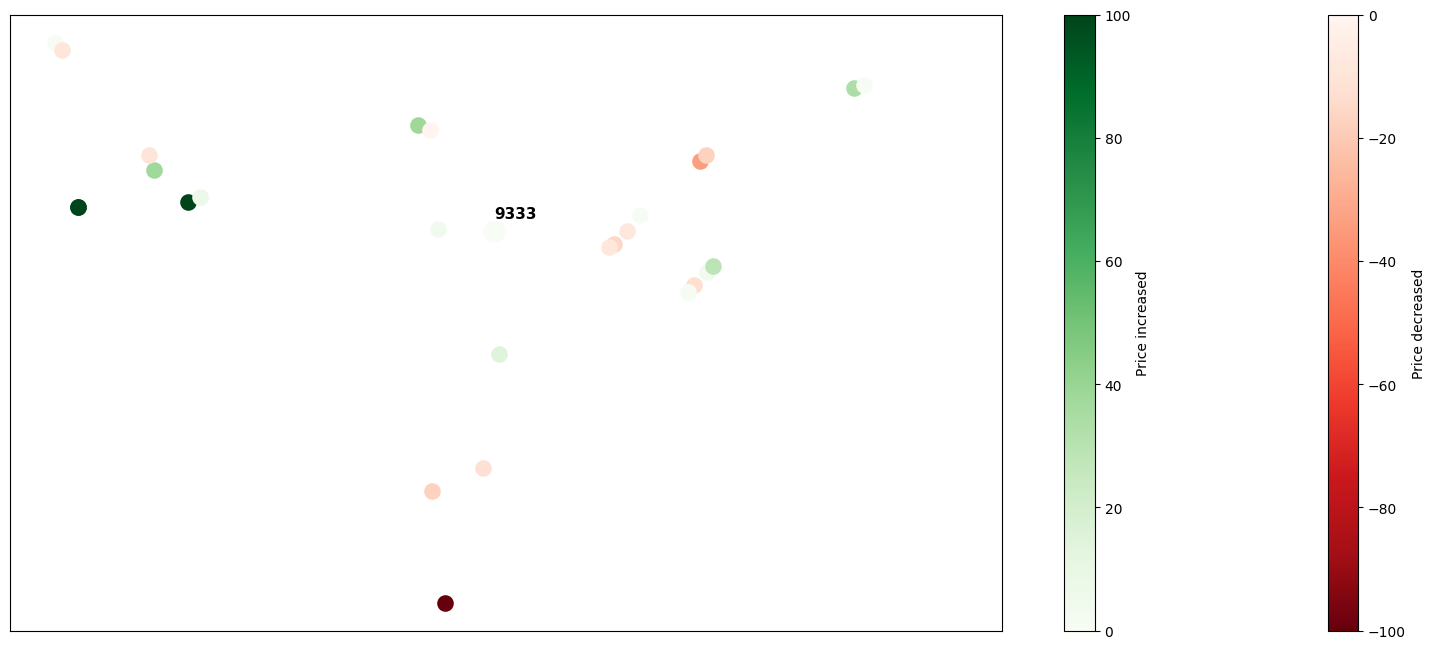

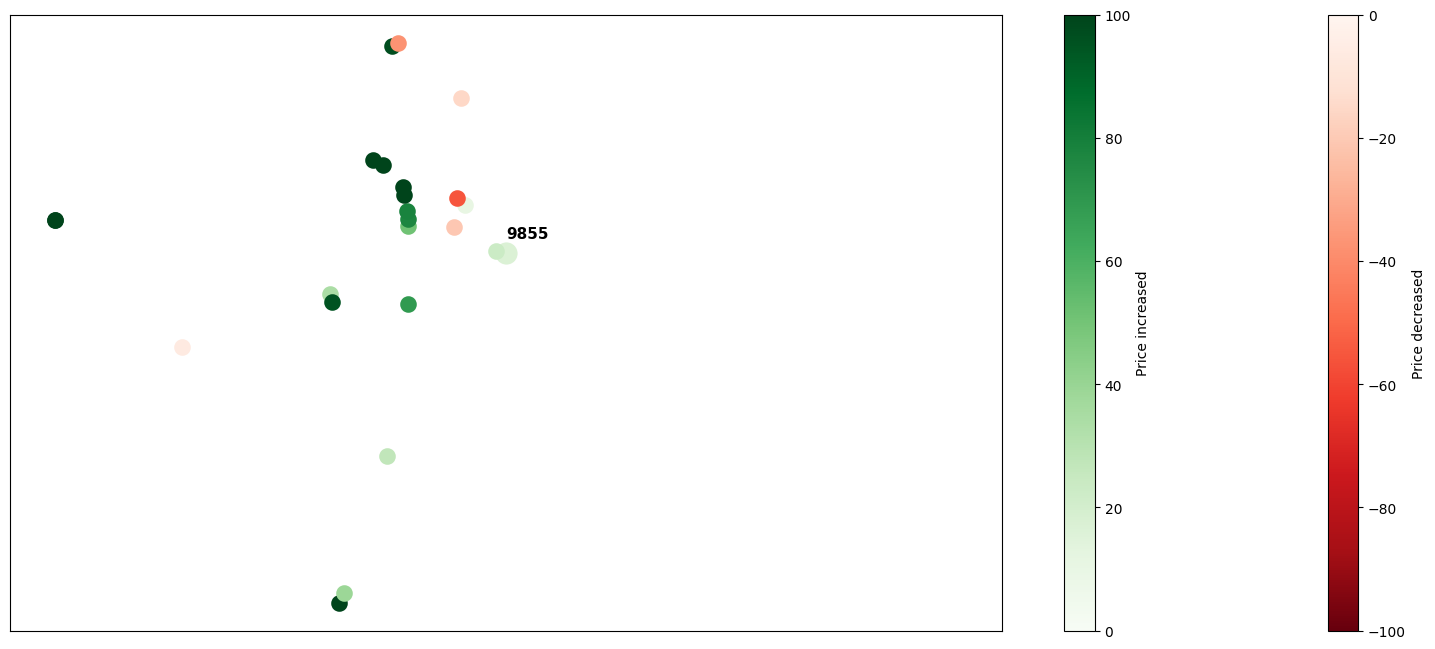

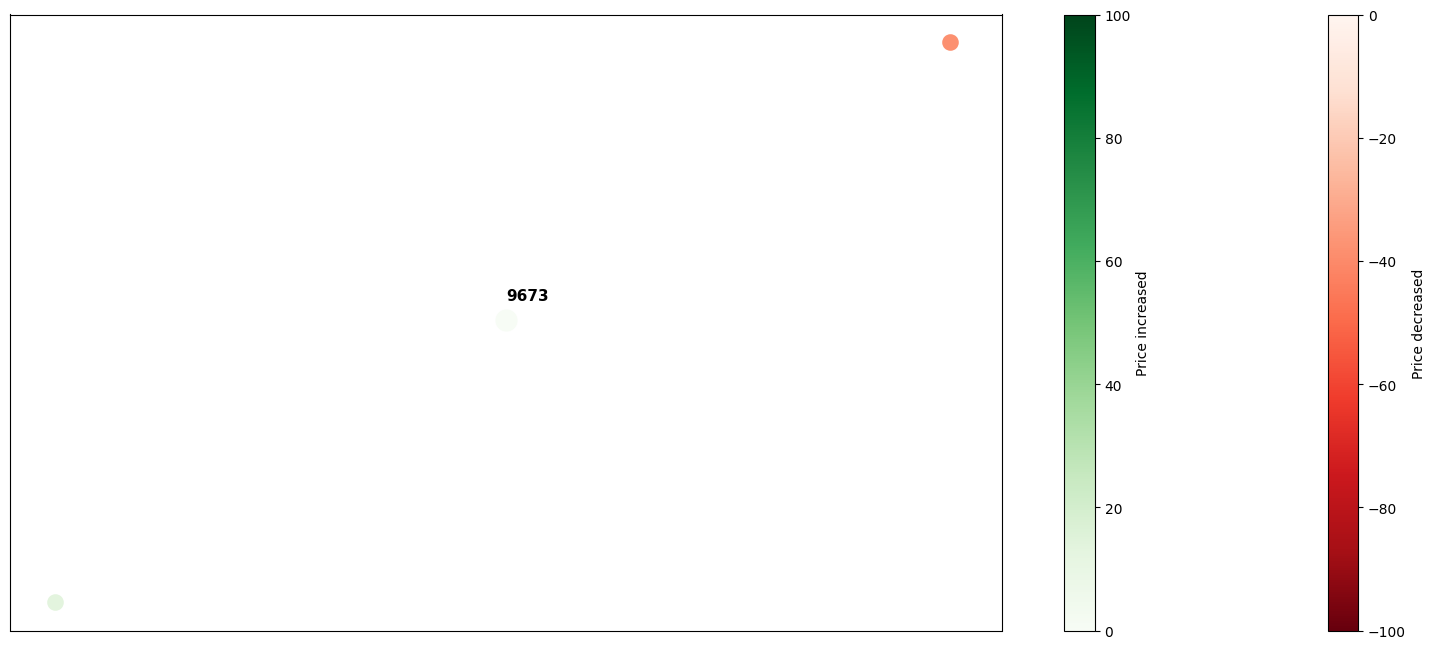

In [494]:
cmap_red = plt.get_cmap('Reds_r')  
cmap_green = plt.get_cmap('Greens')
 
for k, qid in enumerate(qids):
    
    self_coords = data[data.Qid.isin([qid])][["Laenge", "Breite"]].values.T
    neighbours_coords = data[data.Qid.isin(neighbourhood[qid][1:])][["Laenge", "Breite"]].values.T
    
    if len(neighbours_coords[0]):
        
        diff = abs(self_coords[1]-neighbours_coords[1].max())/14
        color = (qid_data[k].Optimal_preis-qid_data[k].Preis)/qid_data[k].Preis*100

        fig, ax = plt.subplots(figsize=(20, 8))
        ax.scatter(*self_coords, linewidths=10, c=[cmap(norm(color[0]))] )
        ax.annotate(xy=(self_coords[0], self_coords[1]+diff), text=int(neighbourhood[qid][0]), weight='bold', size=11)


        for i, neighbour in enumerate(list(map(list, zip(*neighbours_coords)))):
            if color[i+1] > 0:
                cmap = plt.get_cmap('Greens')
                norm = plt.Normalize(0, 20)
            else:
                cmap = plt.get_cmap('Reds_r')
                norm = plt.Normalize(-20, 0)
            ax.scatter(x=neighbour[0], y= neighbour[1], s=80, c=[cmap(norm(color[i+1]))], linewidths=3)
    

        ax.scatter(x=neighbour[0]+2*abs(self_coords[0]-neighbours_coords[0].min()), y=neighbour[1], s=80, c='w', linewidths=3)
        ax.set_facecolor("white")

        sm = plt.cm.ScalarMappable(cmap=cmap_red, norm=plt.Normalize(-100, 0))
        sm.set_array([])  
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Price decreased')  


        sm = plt.cm.ScalarMappable(cmap=cmap_green, norm=plt.Normalize(0, 100))
        sm.set_array([])  
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Price increased')  
        ax.set_xticks([]) 
        ax.set_yticks([]) 

        plt.show()